# Driver Telematics: Detecting driver pattern

# INTRODUCTION

For automobile insurers, telematics represents a growing and valuable way to quantify driver risk. Telematics gives the opportunity to measure the quantity and quality of a driver's behavior. This can lead to savings for safe or infrequent drivers, using a Pay-As-You-Drive model and transition the burden to policies that represent increased liability.

# PROBLEM DEFINITION

The goal is to identify the "telematic fingerprint" capable of distinguishing when a trip was driven by a given driver. 

# DATA

The dataset contains over 50,000 anonymized driver trips. A drive trip is composed of a series of GPS measurements taken each second. Each drive starts at (0, 0) and all the other points are given relative to the origin, in meters. In order to make it harder to match trips to road networks, the trips are randomly rotated and parts from the start and the end removed. A small and random number of false trips are planted for each driver. 
The problem, then, is to deduce the probability that a trip is of a particular driver, based on their telematic features. 

In [17]:
%matplotlib inline


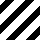
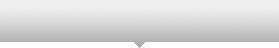
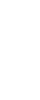
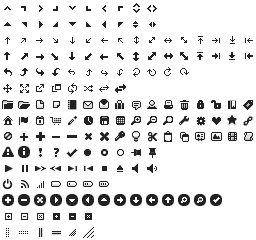
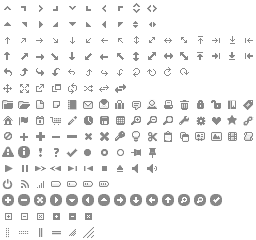
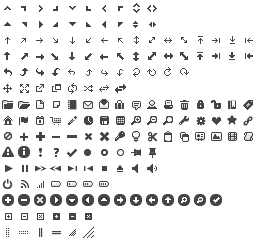
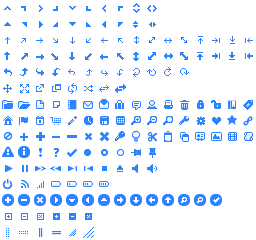
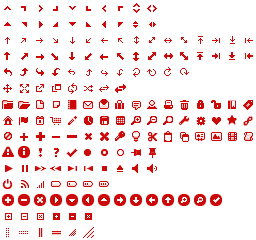
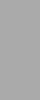
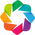
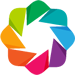
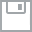
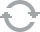
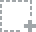
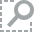
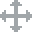
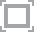
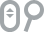

In [18]:
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh import mpl
output_notebook()

### Routes of Driver 12  

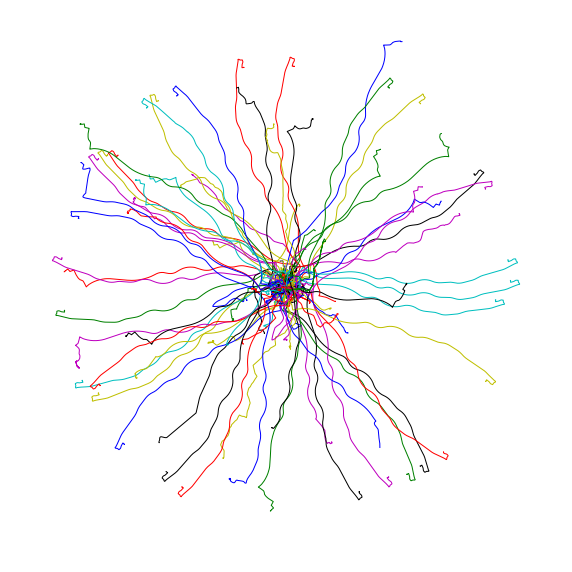

In [13]:
%run D:\python_files\connected_cars\code\plot_route.py

# FEATURE ENGINEERING

Given only GPS coordinates, the following features were engineered:

### Trip Features: 
Max, Avg, Standard Dev of Speed, Acceleration, Deceleration and slip angle. Sudden acceleration or jerk. % of time spent in low speeds, % of stoppage time. % of time spent in different (low, mid, high) speed intervals, outside the Standard FTP Cycle (34.1 km/h (21.2 mph) for city driving). Slip angle over a defined threshhold.

### Features over an interval:
Speed, acceleration, sudden acceleration and slip angle over a 5s sliding window

In [14]:
import numpy as np
import pandas as pd

data = pd.read_csv("D:/python_files/connected_cars/data/feature_data2/Driver1000trips.csv")
data.head()

,id,max_speed,avg_speed,std_dev_speed,avg_acceleration,avg_sudden_acceleration,high_acceleration_time,high_deceleration_time,avg_positive_acceleration,std_dev_positive_acceleration,...,speed_for_high_time_interval,speed_over_ftp_city_limit,slip_over_interval_by_total_dist,slip_over_interval_by_total_time,avg_slip_angle_5s,max_slip_angle_5s,max_speed_5s,avg_speed_5s,sudden_acceleration_5s,driver_id
0,1000_1,6.902898,1.123901,1.369207,-0.004768,0.005701,0.304348,0.313043,0.984080,0.945052,...,0,0,0.043830,0.049020,-0.000494,0.577902,3.626639,1.133306,0.441811,1000
1,1000_10,18.643229,8.267955,5.657144,-0.009918,-0.000293,0.117949,0.143590,0.668669,0.587135,...,0,0,0.000166,0.001370,0.001839,2.057696,16.059719,8.293383,0.782249,1000
2,1000_100,10.358571,3.620147,3.126065,-0.008798,-0.005391,0.076923,0.053846,0.472130,0.415522,...,0,0,0.000000,0.000000,0.004958,1.455520,8.731014,3.680802,0.538083,1000
3,1000_101,24.116799,6.476776,6.632893,-0.001991,0.000393,0.140768,0.141682,0.672765,0.633229,...,0,0,0.000465,0.003012,-0.000475,2.267818,18.883106,6.488367,0.721588,1000
4,1000_102,1.220656,0.175126,0.360064,0.004442,0.005371,0.275862,0.275862,0.490325,0.474509,...,0,0,0.000000,0.000000,0.002355,1.215160,0.505505,0.173690,0.215944,1000


# DATA ANALYSIS

Various plots were constructed to slice and explore the data. From these insights, features like interval limits were derived

### Feature Correlation matrix
Shows the Pearson's correlation of different features. Some features such as avg speed 5s & max speed 5s are highly correlated, and it is possible to reduce the feature set by eliminating redundant features. This can be done as an improvement to the model. For the current model, however, all features were retained. 

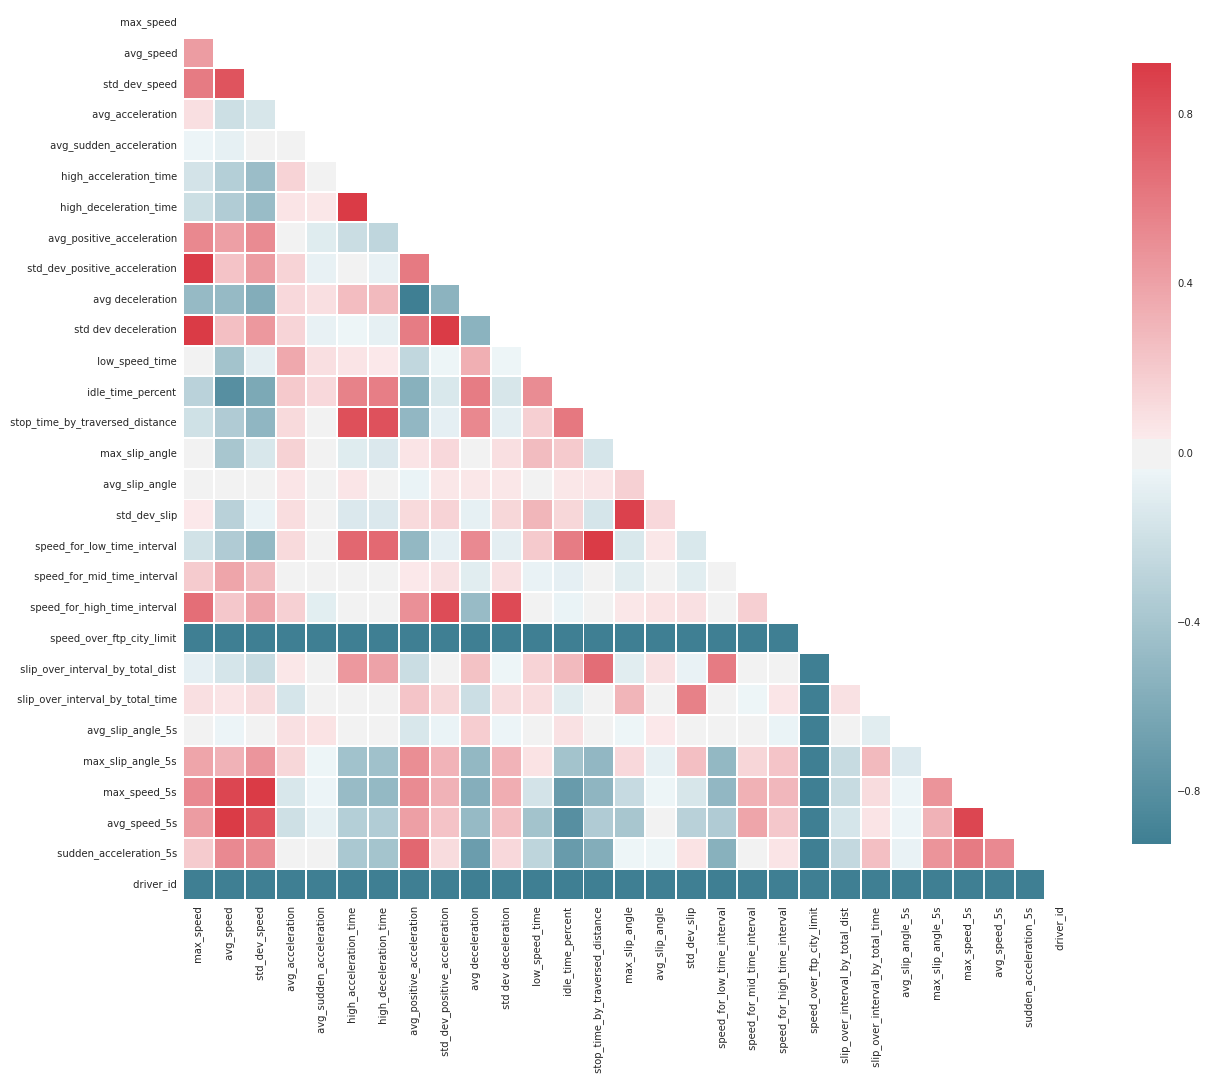

In [32]:
%run D:/python_files/connected_cars/code/plot_correlation_matrix.py

### Plots of speed, acceleration and slip angle
(plotted for some drivers only due to size limitations). The plots give an idea of the typical ranges of speed/acceleration/slips for different drivers, and what are the usual patterns. 

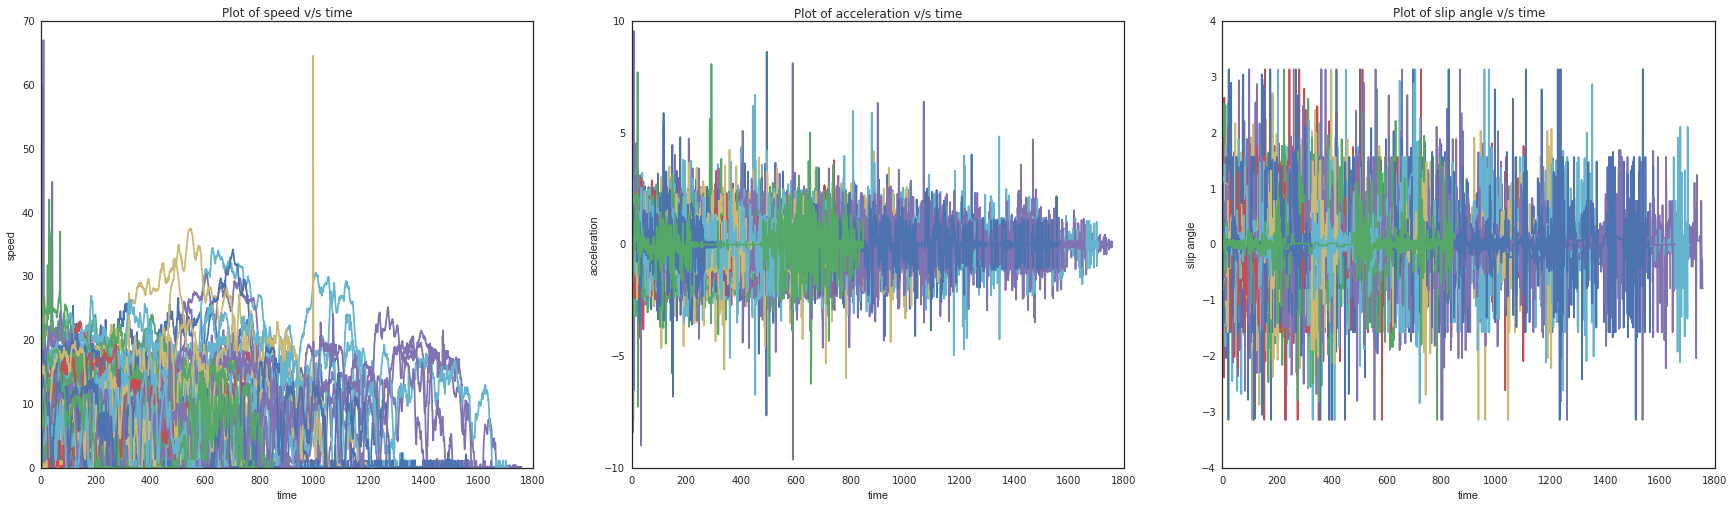

In [59]:
%run D:/python_files/connected_cars/code/plot_acc_speed_slip.py

### Box plots of speed, acceleration and slip angle
(plotted for some drivers only due to size limitations)

Threshholds were derived from box plots for defining interval-based features like speed in low/mid/high ranges, slip over threshholds etc.

In [19]:
%run D:/python_files/connected_cars/code/plot_boxplot.py

## Approach and Models used

Outlier Detection using One-class SVM was initially tried, but it didnt give favourable results. Binary classification model of driver 'x' v/s not driver 'x' was used to arrive at the final estimations.

### Building the training and test sets for Local testing
Each driver has 200 trips. So, 180 trips of Driver X + 180 trips of random sample of other drivers was used to form the Training set, while 20 trips of Driver X + 20 trips of other drivers was used for the test set.

### K-Fold
K=10 fold was used to perform cross-validation on the entire set. So each time, the model was trained/tested on different 180/180 and 20/20 splits of the data

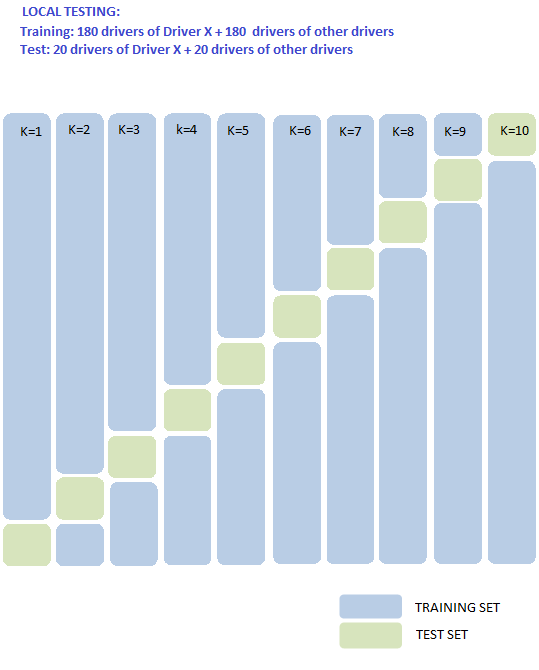

In [5]:
from IPython.display import Image
Image(filename='model.png') 

### Ensemble Model
The model used was an ensemble of 4 classifiers: Logistic Regression, Random Forest, Gradient Boosted Trees and SVM. Some parameter tuning was carried out to arrive at a baseline. A different blend of classifiers was also explored.

Ensembles generally outperform individual classifiers, while also minimizing bias-various problems of a single classifier. Weighted majority voting was applied to get the predicted probabilities on the test set. Higher weights were assigned to Gradient Boosted Trees and SVM.

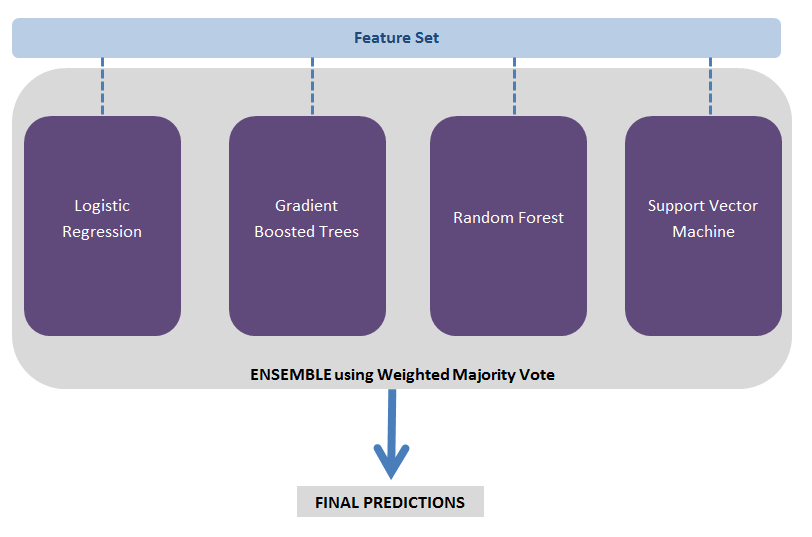

In [6]:
Image(filename='ensemble.png') 

# RESULTS

Model achieved an AUC score of 0.80 (80% accuracy).

# IMPROVEMENTS?

1. Currently working on using Kalman filtering to produce a more smoothed data set (since GPS sensors are noisy!) + quartile features
2. Model hyperparameter tuning
3. Tune model weights in ensemble